In [ ]:
# tutorial not ready

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.stats
import scipy.io
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import maximum_filter1d
from scipy.ndimage.filters import minimum_filter1d
from scipy.ndimage.filters import convolve1d
from scipy.signal import medfilt
from six.moves import urllib
import os
import sklearn.decomposition
import warnings
warnings.simplefilter('ignore')

# download 2-photon data
if not os.path.isfile('data/Fneur_beh.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    with urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/Fneur_beh.npy') as response:
        with open('data/Fneur_beh.npy','wb') as f:
            f.write(response.read())

In [2]:
# DATA preprocessing
# we need to clean up the pupil data
# we need to baseline and deconvolve the calcium fluorescence data
dat = np.load('data/Fneur_beh.npy')
dat = dat.item() # <- dat is a dict so we have to do this

In [ ]:
# clean up pupil data: find outliers and replace them by interpolation

In [64]:
from scipy.ndimage import filters

F = dat['F']

ops = {}
# baseline fluorescence traces recorded with 2p calcium imaging
ops['sig_baseline'] = 10  # adjust this to get desired result
ops['win_baseline'] = 80 # adjust this to get desired result
ops['fs'] = 5

sig = ops['sig_baseline']
win = int(ops['win_baseline']*ops['fs'])    

# smooth the data first, to remove high-frequency noise
Flow = filters.gaussian_filter(F,    [0., sig])

# now run a minimum filter
Flow = filters.minimum_filter1d(Flow,    win)

# now run a maximum filter
Flow = filters.maximum_filter1d(Flow,    win)

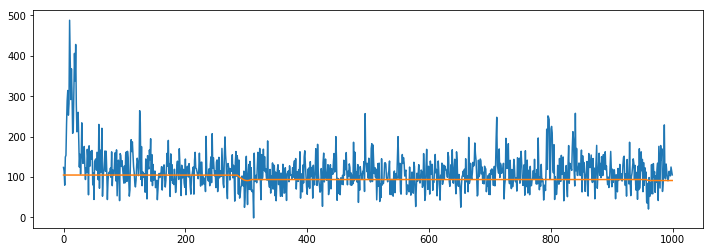

In [65]:
# visualize the baseline for neuron iN
iN = 100
timerange = np.arange(0, 1000)
plt.figure(figsize=(12,4))
plt.plot(F[iN,timerange])
plt.plot(Flow[iN,timerange])
plt.show()

In [66]:
# once we're happy with the parameters, run the baselined data through deconvolution
from suite2p import dcnv

ops['tau'] = 2. # timescale of gcamp sensor
ops['baseline'] = 'none' # we're baselining the data ourselves
F0 = F - Flow
sp = dcnv.oasis(F0, ops) # deconvolve the baselined traces using OASIS

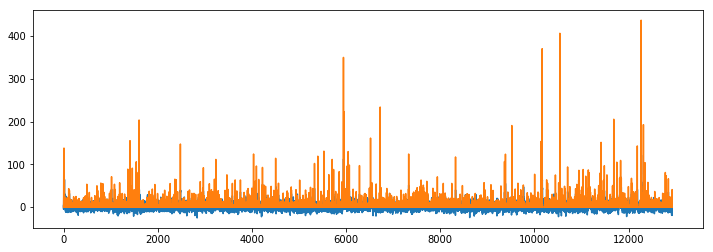

In [70]:
iN = 100
timerange = np.arange(0, sp.shape[1])
plt.figure(figsize=(12,4))
plt.plot(F0[iN,timerange]/5)
plt.plot(sp[iN,timerange])
plt.show()

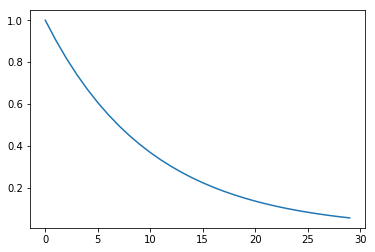

In [71]:
# reconstruct the fluorescence from the deconvolved using the exponential convolution filter
flt  = np.exp(-np.arange(0,3*ops['fs']*ops['tau']) / (ops['tau'] * ops['fs']))
plt.plot(flt)
plt.show()

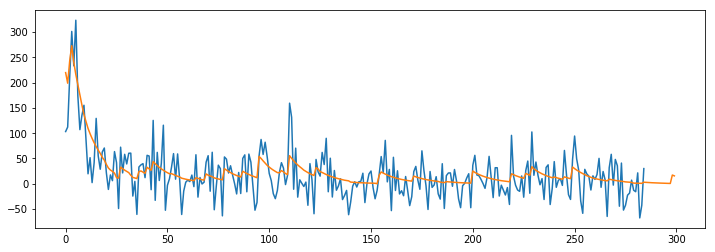

In [73]:
# visualize the reconstruction for neuron iN
iN = 100
timerange = np.arange(0, 300)
Frec = convolve1d(sp, flt, axis=1)

tlag = int(len(flt)/2) # timelag from centering convolve1d

plt.figure(figsize=(12,4))
plt.plot(F0[iN,timerange[tlag:]])
plt.plot(Frec[iN,timerange])
plt.show()

In [74]:
# ready to build some models! 
# use T consecutive samples to predict the T+1-th sample

# normalize spike data
# subtract mean for each neuron
sp  = sp - sp.mean(axis=1)[:,np.newaxis]
# divide by the global standard deviation
sp = sp/np.std(sp)

# we will do this prediction one neuron at a time
iN = 1
nt = sp.shape[1]

# let's make windows of size k (where k is how much history we consider)
k = 100
x = np.zeros((nt-k-1,k+1))
for n in range(nt-k-1):
    x[n,:] = sp[iN, n:n+k+1]
    
# we predict the last sample
y = x[:, k]
# from the first k samples
x = x[:, :k]

# for regression we need the covariance of the inputs
covX = x.T @ x / x.shape[0]
# and the cross-covariance between output and input
xty = x.T @ y / x.shape[0]

# linalg.solve(a,b) solves the equations aw = b, so w = a^-1 * b, which is the solution to our regression problem
w = np.linalg.solve(covX, xty)

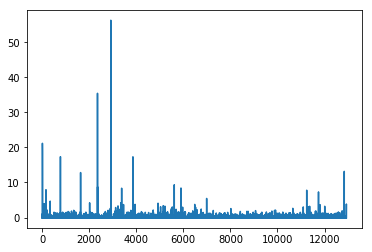

In [77]:
plt.plot(sp[iN,:])

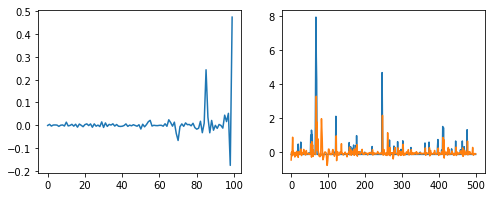

variance explained is 0.27


In [75]:
# now let's plot the filter w, the raw data, and the prediction

# we will make a small function that computes the variance explained
def variance_explained(y,x,w):
    ypred = x @ w
    varres = ((y - ypred)**2).mean()
    varexp = 1 - varres / y[:-1].var()
    return varexp

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,2,1)
ax.plot(w)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(y[:500])
ax2.plot(x[:500,:] @ w)
plt.show()

print('variance explained is %2.2f'%(variance_explained(y,x,w)))

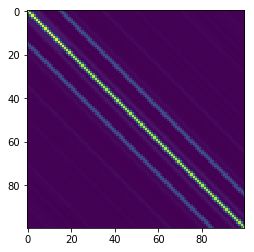

In [76]:
# the covariance in time is a circulant matrix which reflects the autocorrelation function
plt.imshow(covX)
plt.show()

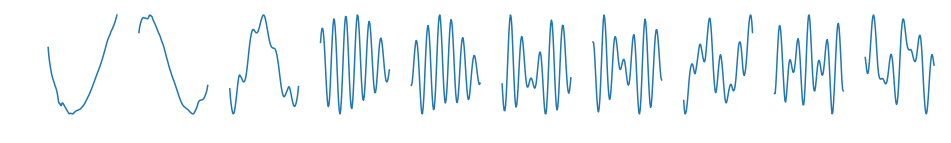

In [12]:
# circulant matrices have PCs which are Fourier modes
svx,ux = scipy.sparse.linalg.eigsh(covX,k=covX.shape[1])
fig = plt.figure(figsize=(16,2))
for k in range(10):
    ax = fig.add_subplot(1,10,k+1)
    ax.plot(ux[:,ux.shape[1]-1-k])
    ax.axis('off')

In [37]:
# single neurons are noisy. Let's combine this with PCA
# decompose data into PCs, predict the PCs

# compute principal components
nPCs = 100 # how many PCs to keep
sv,u  = scipy.sparse.linalg.eigsh(sp @ sp.T, k=nPCs)

u = u[:, ::-1] # PCs come in reverse order
# project data into PCs
tracePC = u.T @ sp

# to reconstruct the data and predictions ,we will do
# sp_rec = u @ tracePC

# the following simply copies the code from above, in a loop for each PC
k = 30
tracePCrec = np.zeros((nPCs,nt-k-1)) # preallocate reconstructed traces
E = np.zeros(nPCs)
for iN in range(nPCs):

    # let's make windows of size k (where k is how much history we consider)
    x = np.zeros((nt-k-1,k+1))
    for n in range(nt-k-1):
        x[n,:] = tracePC[iN, n:n+k+1]
    # we predict the last sample
    y = x[:, k]
    # from the first k samples
    x = x[:, :k]
    # for regression we need the covariance of the inputs
    covX = x.T @ x / x.shape[0]
    # and the cross-covariance between output and input
    xty = x.T @ y / x.shape[0]
    # linalg.solve(a,b) solves the equations aw = b, so w = a^-1 * b, which is the solution to our regression problem
    w = np.linalg.solve(covX, xty)
    # what is the reconstruction of the PC
    tracePCrec[iN, :] = x @ w
    E[iN] = 1-((x@w - y)**2).mean()/y.var()

average explained variance is 0.16


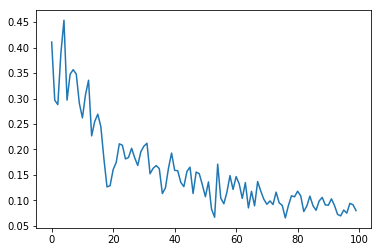

In [38]:
# how much variance is explained in each PC
plt.plot(E)
print('average explained variance is %2.2f'%(E.mean()))
plt.show()
# why do you think it decays as a function of PC#. Make a plot to show it. 

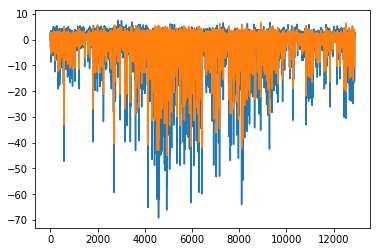

explained variance for PC 0 on this segment is 0.41


In [39]:
# let's plot the reconstructions
iN = 0
NT = tracePC.shape[1]
timerange = np.arange(0, NT-k-1) # plot the whole thing?
#timerange = np.arange(0, 100) zoom in
plt.plot(tracePC[iN, k+timerange]) # we are predicting starting at timepoint k
plt.plot(tracePCrec[iN, timerange])
plt.show()

y = tracePC[iN, k+timerange]
ypred = tracePCrec[iN, timerange]
E = 1 - ((y-ypred)**2).mean()/y.var()
print('explained variance for PC %d on this segment is %2.2f'%(iN, E))


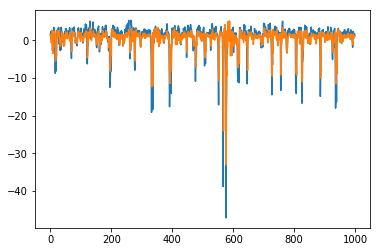

In [40]:
plt.plot(y[:1000])
plt.plot(ypred[:1000])
plt.show()

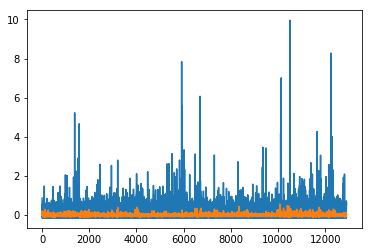

0.018936765596952454


In [42]:
# can we use this to predict single neuron activity? 
sp_rec = u @ tracePCrec

# let's plot the reconstructions
iN = 100
NT = tracePC.shape[1]
timerange = np.arange(0, NT-k-1) # plot the whole thing?
#timerange = np.arange(0, 100) zoom in
plt.plot(sp[iN, k+timerange]) # we are predicting starting at timepoint k
plt.plot(sp_rec[iN, timerange])
plt.show()

y = sp[iN, k+timerange]
ypred = sp_rec[iN, timerange]
E = 1 - ((y-ypred)**2).mean()/y.var()
print(E)

In [ ]:
# can we reconstruct the single neuron filters, based on the PC filters? 

# how about using this to predict one neuron from other neurons? can we reconstruct those filters?

In [ ]:
# how many timesamples in the past do we need? make AR(1), AR(2) models. 
# go back above and replace k with 1, 2, 3, etc where does prediction saturate? 


In [ ]:
# Try basis functions instead with timescales of .5, 1, 2, 4 and 8 frames. 
# filter the PCs with exponential filters, predict from those
# no need to window anymore for this: each exponential filter should be applied convolutionally


In [ ]:
# check out the filters learnt: reconstruct them with the basis functions



In [ ]:
# now let's see if we can predict a PC from other PCs. why would we even try this if the PCs are orthogonal?

In [ ]:
#### add pupil information. First predict only from the pupil, then try basis functions on the pupil
pupraw = dat['pupil_raw']

# 1: median filter pupil trace to remove noise
win = 200
pup = medfilt(pupraw, win*2+1)

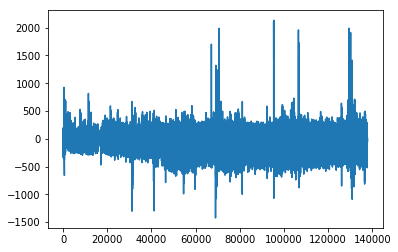

In [30]:
#trange = 94000 + np.arange(0,10000).astype(int)
NTpup = pup.shape[0]
trange = np.arange(0,NTpup)
#plt.plot(pupraw[trange])
#plt.plot(pup[trange])
plt.plot(pup -pupraw)
plt.show()

In [27]:
# 2: align pupil with neural times (pupil is at 50Hz, neural frames at 3Hz)
cam_times = dat['cam_times']
neural_times = dat['neural_times']

# we want the pupil trace at the neural frame times
# why might we smooth the pupil before we interpolate?
pupil = np.interp(neural_times, cam_times, gaussian_filter1d(pup,3))

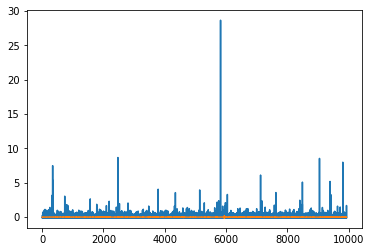

In [131]:
# 3: predict from the pupil

# use multiple timescales of the pupil
pbasis = np.zeros((nt,10))
for n in range(10):
    if n>0:
        pbasis[:,n] = gaussian_filter1d(pupil, n*1)
    else:
        pbasis[:,n] = pupil
        
# let's ignore the beginning of the recording too
pbasis = pbasis[3000:,:]
spcut = sp[:, 3000:]

w = np.linalg.solve(pbasis.T @ pbasis, pbasis.T @ spcut.T)

sp_pred = w.T @ pbasis.T

iN = 3
plt.plot(spcut[iN, :])
plt.plot(sp_pred[iN, :])
plt.show()


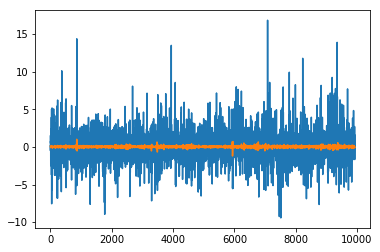

In [136]:
vcut = u.T@spcut

w = np.linalg.solve(pbasis.T @ pbasis, pbasis.T @ vcut.T)

u_pred = w.T @ pbasis.T

iN = 5
plt.plot(vcut[iN, :])
plt.plot(u_pred[iN, :])
plt.show()

In [120]:
print(u.shape)

(1000, 100)


In [2]:
# let's put it all together! predict each PC at time T+1 from all pupil coefficients, 
# same PC coefficients and all other PC coefficients

In [480]:
from scipy.ndimage.filters import convolve1d

expfilt = np.exp(np.arange(0,-8,-1)/2)
#expfilt /= expfilt.sum()
# filter each neuron's timecourse with an exponential filter
spexp = convolve1d(sp, expfilt, axis=1)

(11983, 21055)


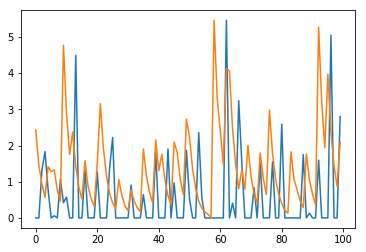

In [481]:
plt.plot(sp[1,:100])
plt.plot(spexp[1,:100])
print(spexp.shape)